# Injecting a sequence of stimuli into a neuron

This notebook demonstrates how we can inject a stimulus with various amplitudes to a cell to compare cell responses.

BlueCelluLab automatically runs NEURON simulations in parallel on separate processes to enable process isolation.

**Note**: There always has to be a single NEURON simulation running on a process.

### Compiling the mechanisms

Before loading the cell, the cell mechanisms need to be compiled and provided. With NEURON installed, simply run the following command for the compilation.

In [ ]:
!nrnivmodl ../mechanisms

In [2]:
from pathlib import Path
from bluecellulab.analysis.inject_sequence import apply_multiple_stimuli, StimulusName
from bluecellulab import EmodelProperties, Cell
import matplotlib.pyplot as plt

--No graphics will be displayed.


### Loading the Neuron Model

We load the neuron model that we'll be using for our simulation. The neuron model is specified through a morphology file and a hoc file. The hoc file contains the NEURON code defining the neuron's physiology, while the morphology file defines the neuron's shape and structure. In this tutorial, we will use a Pyramidal neuron model.

In [3]:
# Define the base directory
base_dir = Path("../1-singlecell/")

# Define the hoc and morphology files
hoc_file = base_dir / "hoc" / "cADpyr_L2TPC.hoc"
morph_file = base_dir / "morphology" / "rr110330_C3_idA.asc"

emodel_properties = EmodelProperties(threshold_current=0.03203125,
                                     holding_current=-0.11,
                                     AIS_scaler=1.11)
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

The cell is loaded and its sections can be displayed now. 

In [4]:
# show 10 sections of dict
list(cell.sections.items())[:10]

[('soma[0]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].soma[0]),
 ('dend[0]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[0]),
 ('dend[1]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[1]),
 ('dend[2]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[2]),
 ('dend[3]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[3]),
 ('dend[4]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[4]),
 ('dend[5]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[5]),
 ('dend[6]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[6]),
 ('dend[7]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[7]),
 ('dend[8]', cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[8])]

We need to specify the v_init for the cell to show correct responses. In BlueCellulab, these are defined in NeuronGlobals. It currently has `v_init` and `celsius` with default values of -65 mV and 34.0 degree celsius respectively. We can change these values as per our requirement.

To do that, we first create an instance of the class and then set the v_init value. The default value of `celsius` (34.0) is the same as the model. So, we don't set it again.

In [5]:
from bluecellulab.simulation.neuron_globals import NeuronGlobals
ng = NeuronGlobals.get_instance()
ng.v_init = -80

### Applying multiple Fire Pattern Stimuli on our cell (neuron)

We will apply multiple Fire Pattern stimuli to our cell and compare the responses.

The amplitudes represent the percentage of threshold current that we will apply to the cell.

In other words, amplitude 120 means 120% of the cell's own threshold current will be injected to the cell.

In [6]:
amplitudes = [40, 60, 80, 100, 110, 120]
responses = apply_multiple_stimuli(cell, StimulusName.FIRE_PATTERN, amplitudes, section_name="soma[0]")

`responses` is a dictionary stimulus name as dictionary with stimulus name for different amplitudes as dictionary keys and the response as dictionary values. Each response has a recording arrays of time, stimulus current and membrane voltage which can be accessed as response.time, response.current and response.voltage respectively. The `plot_responses` function below can be used to plot the responses.

In [7]:
responses

{'StimulusName.FIRE_PATTERN_40': Recording(current=array([0., 0., 0., ..., 0., 0., 0.]), voltage=array([-80.        , -80.00218498, -80.00422193, ..., -85.13490197,
        -85.13490197, -85.13470262]), time=array([0.00000000e+00, 4.58438407e-03, 9.16876815e-03, ...,
        4.09900000e+03, 4.09900000e+03, 4.10000000e+03])),
 'StimulusName.FIRE_PATTERN_60': Recording(current=array([0., 0., 0., ..., 0., 0., 0.]), voltage=array([-80.        , -80.00218498, -80.00422193, ..., -85.13707376,
        -85.13707376, -85.13677618]), time=array([0.00000000e+00, 4.58438407e-03, 9.16876815e-03, ...,
        4.09900000e+03, 4.09900000e+03, 4.10000000e+03])),
 'StimulusName.FIRE_PATTERN_80': Recording(current=array([0., 0., 0., ..., 0., 0., 0.]), voltage=array([-80.        , -80.00218498, -80.00422193, ..., -85.13929982,
        -85.13929982, -85.13889881]), time=array([0.00000000e+00, 4.58438407e-03, 9.16876815e-03, ...,
        4.09900000e+03, 4.09900000e+03, 4.10000000e+03])),
 'StimulusName.FIRE

We will use the following function to plot the results.

In [8]:
def plot_responses(responses):
    """Plot time vs voltage and time vs current for all stimuli."""
    title_fontsize = 16
    label_fontsize = 16
    tick_fontsize = 14
    legend_fontsize = 14

    fig, ax  = plt.subplots(nrows = 1, ncols = 2, figsize=(24, 8))
    for stimulus, recording in responses.items():
        label_txt = f'{stimulus.split(".")[1].title().replace("_", " ")} %'
        ax[0].plot(recording.time, recording.current, label=label_txt, alpha=0.8)
        ax[1].plot(recording.time, recording.voltage, label=label_txt, alpha=0.8)

    ax[0].legend(fontsize=legend_fontsize)
    ax[0].set_title(f'Injected Current', fontsize=title_fontsize)
    ax[0].set_xlabel('Time (ms)', fontsize=label_fontsize)
    ax[0].set_ylabel('Injected Current (nA)', fontsize=label_fontsize)
    ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

    ax[1].legend(fontsize=legend_fontsize, loc='upper right')
    ax[1].set_title(f'Cell Response', fontsize=title_fontsize)
    ax[1].set_xlabel('Time (ms)', fontsize=label_fontsize)
    ax[1].set_ylabel('Membrane Potential (mV)', fontsize=label_fontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

    # set xlim to the begining and end of the stimulus
    ax[0].set_xlim(0, recording.time[-1])
    ax[1].set_xlim(0, recording.time[-1])

    title = ''
    if "FIRE_PATTERN" in stimulus:
        title = f'FirePattern Stimulus Cell Response'
    elif "IV" in stimulus:
        title = f'IV Stimulus Cell Response'
    elif "POS_CHEOPS" in stimulus:
        title = f'POSCHEOPS Stimulus Cell Response'

    fig.suptitle(title ,fontsize=20)

    # plt.xticks(fontsize=tick_fontsize)
    # plt.yticks(fontsize=tick_fontsize)
    plt.tight_layout()
    return plt

### Displaying the results

The 2 figures below show the current and voltage responses of the cell to the sequence of stimuli injected.

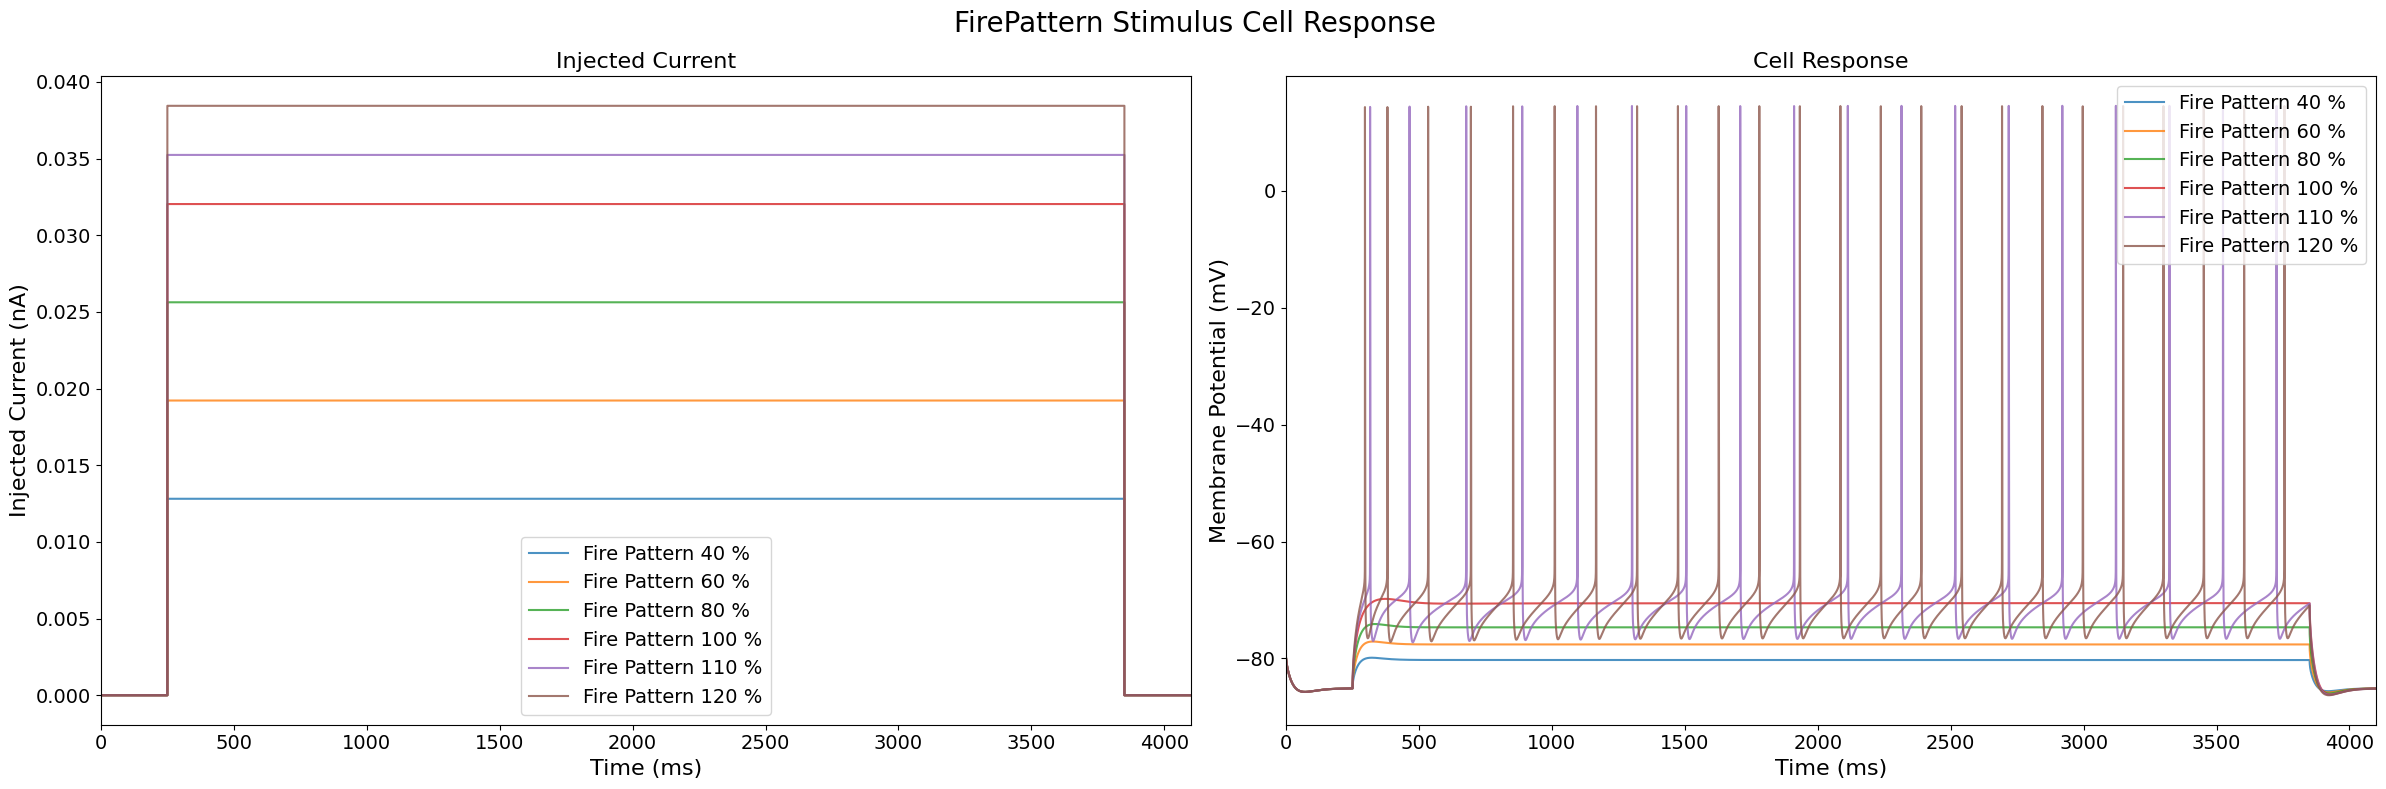

In [9]:
plt = plot_responses(responses)
plt.show()

The % value in the legend represents the amplitude of the stimulus as a percentage of the cell's threshold current. The y axis in the left figure shows the absolute value of the current injected.

### Applying the IV stimuli on the dendrite of the cell

By default the stimuli are applied to the soma of the cell. We can also apply the stimuli to the dendrite of the cell by changing the `section_name` parameter in the `apply_multiple_stimuli` function.

Displaying the available sections within our cell.

In [10]:
cell.sections

{'soma[0]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].soma[0],
 'dend[0]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[0],
 'dend[1]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[1],
 'dend[2]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[2],
 'dend[3]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[3],
 'dend[4]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[4],
 'dend[5]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[5],
 'dend[6]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[6],
 'dend[7]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[7],
 'dend[8]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[8],
 'dend[9]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[9],
 'dend[10]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[10],
 'dend[11]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[11],
 'dend[12]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[12],
 'dend[13]': cADpyr_L2TPC_bluecellulab_0x7fff49aafb90[0].dend[13],
 'dend[14]': cADp

In [11]:
amplitudes = [-20, -40, -60, -80]
iv_responses = apply_multiple_stimuli(cell, StimulusName.IV, amplitudes, section_name="dend[23]")

In [12]:
iv_responses["StimulusName.IV_-20"]

Recording(current=array([0., 0., 0., ..., 0., 0., 0.]), voltage=array([-80.        , -80.00062795, -80.00125613, ..., -84.567072  ,
       -84.567072  , -84.5674263 ]), time=array([0.00000000e+00, 4.58438407e-03, 9.16876815e-03, ...,
       3.49900000e+03, 3.49900000e+03, 3.50000000e+03]))

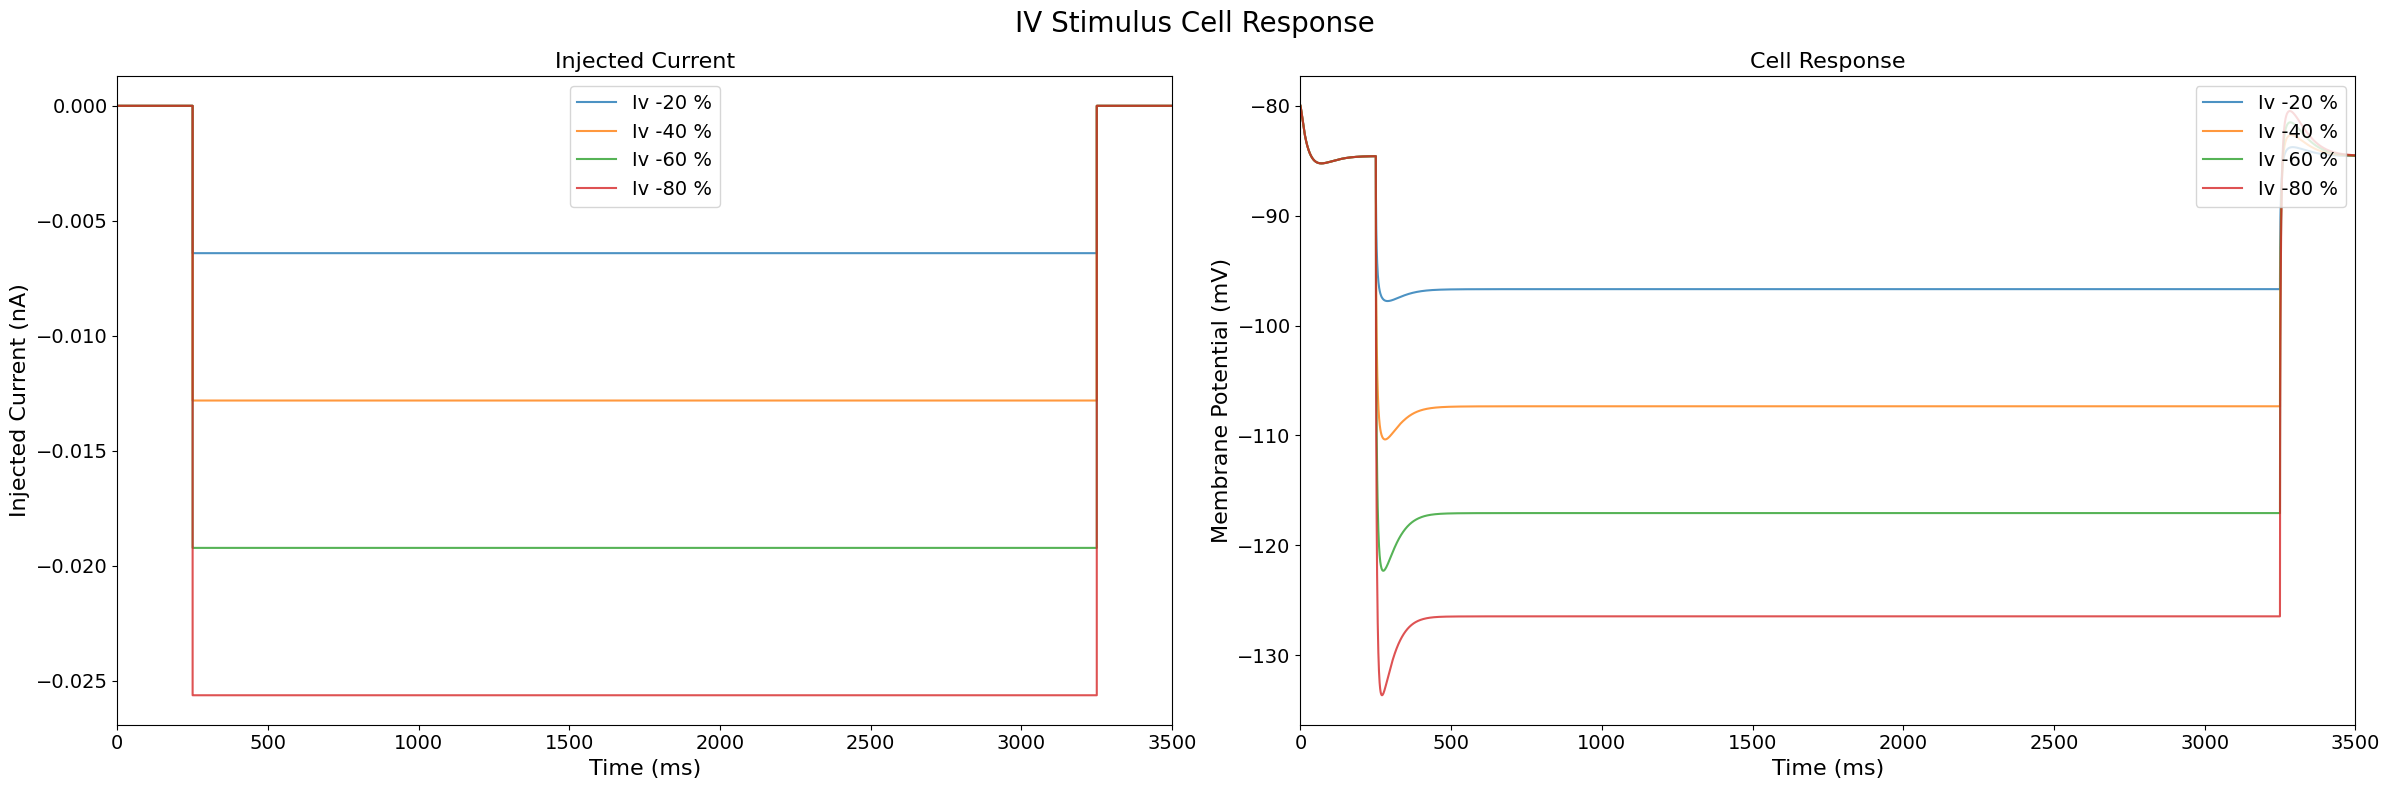

In [13]:
plt = plot_responses(iv_responses)
plt.show()

In [14]:
amplitudes = [40, 60, 80, 100, 110, 120]
responses = apply_multiple_stimuli(cell, StimulusName.POS_CHEOPS, amplitudes, section_name="soma[0]")

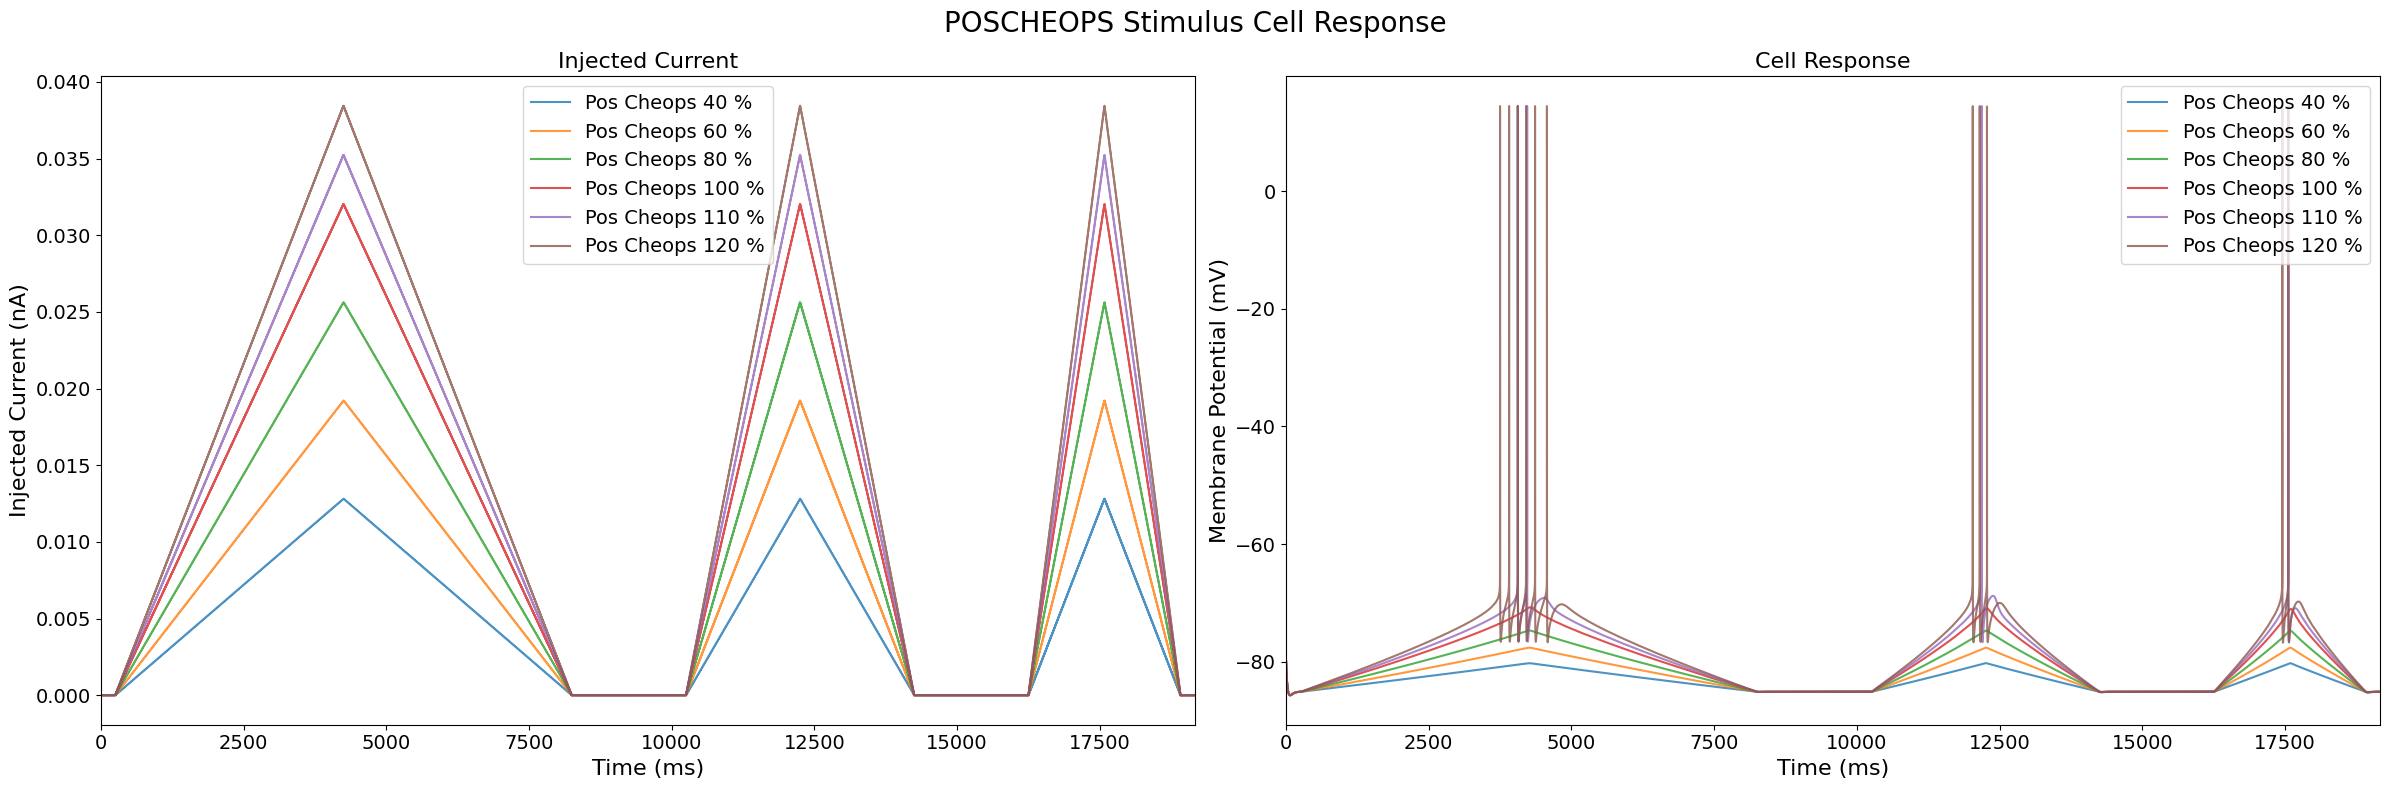

In [15]:
plt = plot_responses(responses)
plt.show()

More information on the available stimuli can be found at the documentation: https://bluecellulab.readthedocs.io/en/latest/